In [415]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn.pool import graclus
from torch_geometric.data import Data
import random

In [391]:
def visualize_graph(G, clusters, title):
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    c = [
    "red", "blue", "green", "orange", "yellow", "purple", "pink", "grey", "brown", "cyan",
    "magenta", "lime", "maroon", "navy", "olive", "teal", "violet", "indigo", "gold", "silver",
    "coral", "turquoise", "beige", "lavender", "salmon", "khaki", "plum", "orchid", "tan", "peru",
    "crimson", "azure", "chartreuse", "slateblue", "springgreen", "darkcyan", "hotpink", "lightseagreen",
    "sienna", "firebrick", "darkorchid", "mediumvioletred", "steelblue", "darkorange", "dodgerblue",
    "seagreen", "mediumaquamarine", "darkslategray", "rosybrown", "deepskyblue", "palevioletred", "cadetblue",
    "goldenrod", "mediumslateblue", "lightcoral", "mediumseagreen", "indianred", "forestgreen", "darkmagenta",
    "orangered", "mediumpurple", "darkred", "limegreen", "slategray", "darkolivegreen", "blueviolet", "royalblue", "red", "blue", "green", "orange", "yellow", "purple", "pink", "grey", "brown", "cyan",
    "magenta", "lime", "maroon", "navy", "olive", "teal", "violet", "indigo", "gold", "silver",
    "coral", "turquoise", "beige", "lavender", "salmon", "khaki", "plum", "orchid", "tan", "peru",
    "crimson", "azure", "chartreuse", "slateblue", "springgreen", "darkcyan", "hotpink", "lightseagreen",
    "sienna", "firebrick", "darkorchid", "mediumvioletred", "steelblue", "darkorange", "dodgerblue",
    "seagreen", "mediumaquamarine", "darkslategray", "rosybrown", "deepskyblue", "palevioletred", "cadetblue",
    "goldenrod", "mediumslateblue", "lightcoral", "mediumseagreen", "indianred", "forestgreen", "darkmagenta",
    "orangered", "mediumpurple", "darkred", "limegreen", "slategray", "darkolivegreen", "blueviolet", "royalblue", "red", "blue", "green", "orange", "yellow", "purple", "pink", "grey", "brown", "cyan",
    "magenta", "lime", "maroon", "navy", "olive", "teal", "violet", "indigo", "gold", "silver",
    "coral", "turquoise", "beige", "lavender", "salmon", "khaki", "plum", "orchid", "tan", "peru",
    "crimson", "azure", "chartreuse", "slateblue", "springgreen", "darkcyan", "hotpink", "lightseagreen",
    "sienna", "firebrick", "darkorchid", "mediumvioletred", "steelblue", "darkorange", "dodgerblue",
    "seagreen", "mediumaquamarine", "darkslategray", "rosybrown", "deepskyblue", "palevioletred", "cadetblue",
    "goldenrod", "mediumslateblue", "lightcoral", "mediumseagreen", "indianred", "forestgreen", "darkmagenta",
    "orangered", "mediumpurple", "darkred", "limegreen", "slategray", "darkolivegreen", "blueviolet", "royalblue"
]
    colors = [c[clusters[node]] for node in G.nodes()]
    
    nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.Set1, node_size=500, edge_color="gray")
    plt.title(title)
    plt.show()


In [403]:
def squeeze_clusters(clusters):
    d = 0
    correspondence = {}
    for i, cluster in enumerate(clusters):
        if not (cluster.item() in correspondence):
            correspondence[cluster.item()] = d
            d += 1
    return [correspondence[cluster.item()] for cluster in clusters], d

def toAssignMatrix(clusters, num_clusters):
    S = torch.zeros(len(clusters), num_clusters)
    S[torch.arange(len(clusters)), clusters] = 1
    return S

def apply_graclus(adj, edge_index, weights):
    clusters = graclus(edge_index, weight=weights, num_nodes=adj.shape[0])
    clusters, num_clusters = squeeze_clusters(clusters)
    assign_matrix = toAssignMatrix(clusters, num_clusters)
    print(assign_matrix.shape)
    adj = assign_matrix.T @ adj @ assign_matrix
    adj[torch.arange(adj.shape[0]), torch.arange(adj.shape[0])] = 0
    edge_index = torch.where(torch.triu(adj, diagonal=1))
    edge_index = torch.cat([edge_index[0].unsqueeze(0), edge_index[1].unsqueeze(0)], axis=0).int()
    weights = [adj[edge_index[0, i], edge_index[1, i]].int().item() for i in range(edge_index.shape[1])]

    return adj, edge_index, weights, assign_matrix

def iterative_graclus(G, assign_ratio, max_iters = 10):
    num_nodes = G.number_of_nodes()
    target_num_clusters = int(num_nodes * assign_ratio)

    adj = torch.tensor(nx.to_numpy_array(G)).float()
    edge_index = torch.tensor(list(G.edges())).T
    weights = torch.ones(edge_index.shape[1])

    assign_matrix = torch.eye(num_nodes)

    assign_matrices = []
    iters = 0
    while target_num_clusters < assign_matrix.shape[1] and iters < max_iters:
        assign_matrices.append(assign_matrix)
        iters += 1

        adj, edge_index, weights, assign_matrix = apply_graclus(
            adj, 
            edge_index.long(), 
            torch.tensor(weights).float()
        )

    assign_matrix = assign_matrices[0]
    for a in assign_matrices:
        assign_matrix @= a

    return assign_matrices, adj, assign_matrix

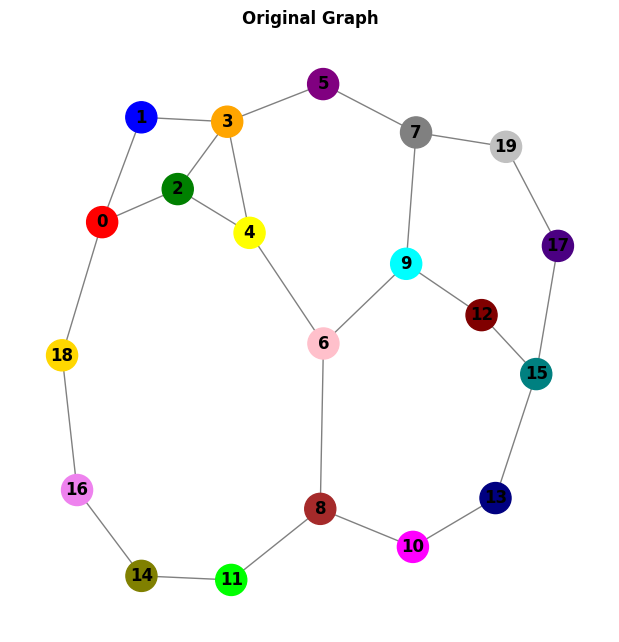

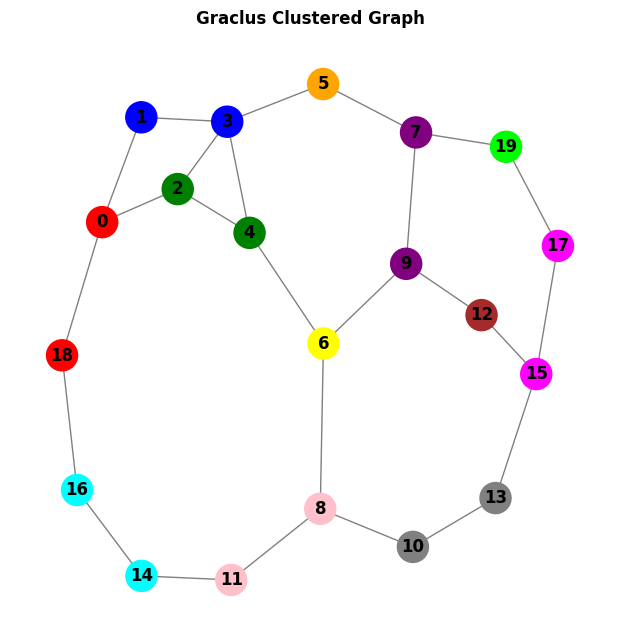

[0, 1, 2, 1, 2, 3, 4, 5, 6, 5, 7, 6, 8, 7, 9, 10, 9, 10, 0, 11]


In [395]:
# 1. Create a synthetic graph
edge_index = torch.tensor([
    [0, 0, 1, 2, 2, 3, 3, 4, 5, 6, 6, 7, 8, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    [1, 2, 3, 3, 4, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 12, 13, 14, 15, 15, 16, 17, 18, 19, 0, 7]
])  # Undirected graph edges

num_nodes = edge_index.max().item() + 1  # Count total nodes
data = Data(edge_index=edge_index, num_nodes=num_nodes)

clusters = graclus(data.edge_index, num_nodes=num_nodes)

G = nx.Graph()
G.add_edges_from(edge_index.T.tolist())


# 6. Plot original and clustered graph
clusters, num_clusters = squeeze_clusters(clusters)
visualize_graph(G, {i: i for i in range(num_nodes)}, "Original Graph")
visualize_graph(G, clusters, "Graclus Clustered Graph")
print(clusters)

In [409]:
num_nodes = 150
num_edges = 300  # Adjust the number of edges

# Generate a random graph
G = nx.gnm_random_graph(num_nodes, num_edges)

assign_matrices, adj, assign_matrix = iterative_graclus(G, 0.1)

clusters = torch.where(assign_matrix != 0)[1]
print(clusters)

# visualize_graph(G, {i: i for i in range(num_nodes)}, "Original Graph")
# visualize_graph(G, clusters, "Graclus Clustered Graph")
# print(clusters)

torch.Size([150, 104])
torch.Size([104, 71])
torch.Size([71, 49])
torch.Size([49, 32])
torch.Size([32, 22])
torch.Size([22, 15])
tensor([ 0,  1,  2,  3,  4,  1,  5,  6,  6,  1,  2,  7,  8,  9,  6, 10,  6, 11,
         6, 12,  7, 13,  6, 14, 10,  2,  2,  5,  4, 10,  3, 15,  2, 14,  1,  6,
         2, 10,  2, 16,  8, 16, 14,  2, 12, 17,  2,  7,  6,  6,  2, 16,  0,  2,
         4, 15, 17, 18,  5, 12,  1, 16, 14,  2,  1, 15,  2,  1,  1, 10,  6, 16,
         2, 16, 14, 16, 14,  8,  8,  1,  3, 16,  1,  6, 14,  1, 12, 19, 14, 14,
        15, 14,  0, 16, 17,  0, 15, 20,  8,  2, 15,  2,  6,  2,  1,  8, 14,  1,
        10, 15, 10,  7, 14, 12, 14, 16, 14,  2, 19,  1,  6,  0, 15,  0,  8, 15,
         5,  6, 12, 16,  6, 21,  1,  2, 10, 14, 16,  1, 10,  6, 14,  1,  1, 14,
         6,  1, 14, 14,  6,  7])


C:\Users\aa310\AppData\Local\Temp\ipykernel_15576\2836517231.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weights).float()


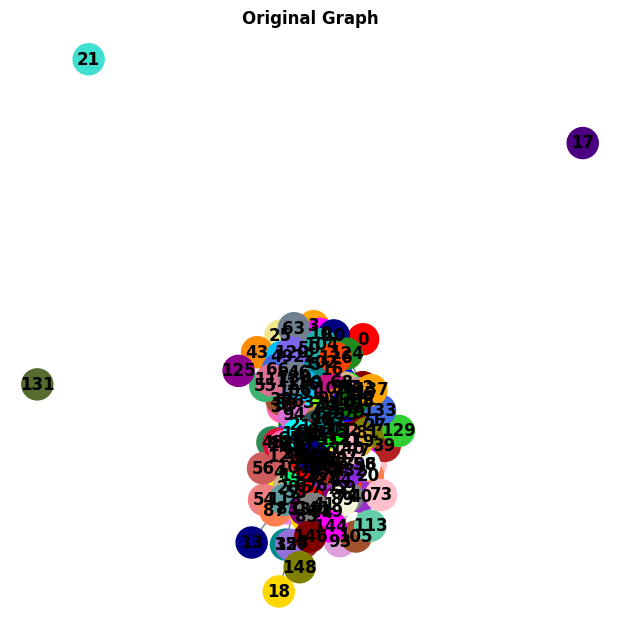

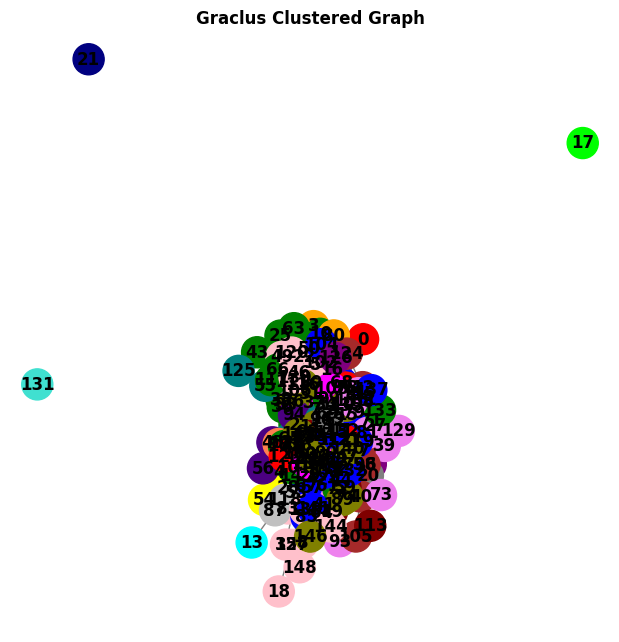

In [411]:
visualize_graph(G, {i: i for i in range(G.number_of_nodes())}, "Original Graph")
visualize_graph(G, clusters, "Graclus Clustered Graph")

In [161]:
num_nodes

20

In [281]:
assign_matrices, adj = iterative_graclus(G, 0.2)
print(adj)

tensor([[0., 2., 0.],
        [2., 0., 3.],
        [0., 3., 0.]])


C:\Users\aa310\AppData\Local\Temp\ipykernel_15576\344150436.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weights).float()


In [149]:
G

In [145]:
assign_matrix[0, 1]

tensor(0.)

In [325]:
adj, edge_index, weights, assign_matrix = apply_graclus(
    torch.tensor(nx.to_numpy_array(G)).float(), 
    torch.tensor(list(G.edges())).T, 
    torch.ones(torch.tensor(list(G.edges())).T.shape[1]))
print(type(torch.tensor(nx.to_numpy_array(G)).float()))
print(type(torch.tensor(list(G.edges())).T))
print(type(torch.ones(torch.tensor(list(G.edges())).T.shape[1])))
print(torch.tensor(nx.to_numpy_array(G)).float().dtype)
print(torch.tensor(list(G.edges())).T.dtype)
print(torch.ones(torch.tensor(list(G.edges())).T.shape[1]).dtype)
print(assign_matrix.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.float32
torch.int64
torch.float32
torch.Size([150, 97])


In [333]:
print(adj.shape)
print(edge_index.shape)
print(len(weights))

torch.Size([97, 97])
torch.Size([2, 484])
484


In [331]:
edge_index

tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  6,  6,
          6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  9,  9,  9,  9,  9,  9,  9,  9,
         10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13,
         13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15,
         16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23,
         23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
         26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
         30, 30, 30, 31, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34,
         34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 37, 37, 37, 37, 37,
         37, 37, 37, 38, 38,

In [317]:
print(type(adj))
print(type(edge_index))
print(type(torch.tensor(weights).float()))
print(adj.dtype)
print(edge_index.long().dtype)
print(torch.tensor(weights).float().dtype)
adj, edge_index, weights, assign_matrix = apply_graclus(
    adj, 
    edge_index.long(), 
    torch.tensor(weights).float())

print(assign_matrix.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.float32
torch.int64
torch.float32
torch.Size([150, 9])


In [355]:
G.edges()

EdgeView([(0, 149), (0, 90), (0, 25), (0, 74), (0, 142), (1, 4), (1, 73), (1, 25), (1, 83), (1, 86), (1, 140), (1, 129), (1, 41), (1, 9), (2, 46), (2, 36), (2, 23), (2, 47), (2, 80), (3, 137), (3, 127), (3, 23), (3, 96), (4, 137), (6, 134), (6, 39), (6, 133), (6, 42), (7, 83), (7, 115), (7, 75), (7, 19), (7, 143), (7, 126), (8, 69), (8, 67), (8, 138), (9, 95), (9, 50), (9, 86), (10, 97), (10, 44), (11, 43), (12, 104), (12, 111), (12, 47), (12, 79), (13, 27), (13, 149), (13, 34), (14, 134), (14, 104), (14, 81), (14, 126), (14, 63), (14, 149), (15, 68), (16, 47), (16, 122), (16, 83), (17, 126), (17, 55), (17, 90), (17, 137), (17, 121), (18, 134), (18, 112), (18, 78), (19, 55), (19, 27), (20, 103), (20, 101), (20, 108), (20, 86), (21, 50), (21, 47), (21, 137), (21, 72), (21, 58), (21, 134), (21, 32), (21, 138), (22, 132), (22, 80), (22, 28), (22, 41), (24, 121), (24, 141), (25, 65), (25, 145), (25, 76), (25, 52), (25, 43), (26, 149), (26, 104), (26, 140), (26, 30), (27, 121), (27, 136), (

In [361]:
torch.where(adj != 0)

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
          9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 17, 17, 17, 18, 18, 20, 20]),
 tensor([ 1,  2,  3,  6,  7,  8,  9, 11, 13, 14, 15, 16, 18, 20,  0,  2,  3,  5,
          6,  8,  9, 10, 11, 12, 13, 14, 15, 16,  0,  1,  3,  5,  6,  8, 10, 11,
         13, 14, 15, 20,  0,  1,  2,  6, 11, 12, 13, 14, 1

In [363]:
torch.where(torch.triu(adj, diagonal=1))

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  3,  3,  3,  3,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  9,  9,  9,  9,  9,  9, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 13, 14, 14, 14, 15]),
 tensor([ 1,  2,  3,  6,  7,  8,  9, 11, 13, 14, 15, 16, 18, 20,  2,  3,  5,  6,
          8,  9, 10, 11, 12, 13, 14, 15, 16,  3,  5,  6,  8, 10, 11, 13, 14, 15,
         20,  6, 11, 12, 13, 14, 15, 16,  6, 10, 11, 12, 13, 14, 16,  7,  9, 10,
         11, 13, 14, 15, 16, 10, 13, 15, 16, 15, 17, 10, 12, 13, 14, 15, 17, 11,
         13, 15, 16, 18, 12, 13, 14, 15, 16, 15, 15, 16, 17, 16]))

In [429]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]

In [431]:
def shuffle_together(*args):
    zipped = list(zip(*args))
    random.shuffle(zipped)
    return [list(x) for x in zip(*zipped)]

In [433]:
shuffle_together(a, b)

[[7, 8, 3, 6, 2, 4, 5, 10, 9, 1],
 ['g', 'h', 'c', 'f', 'b', 'd', 'e', 'j', 'i', 'a']]